In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [69]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [137]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

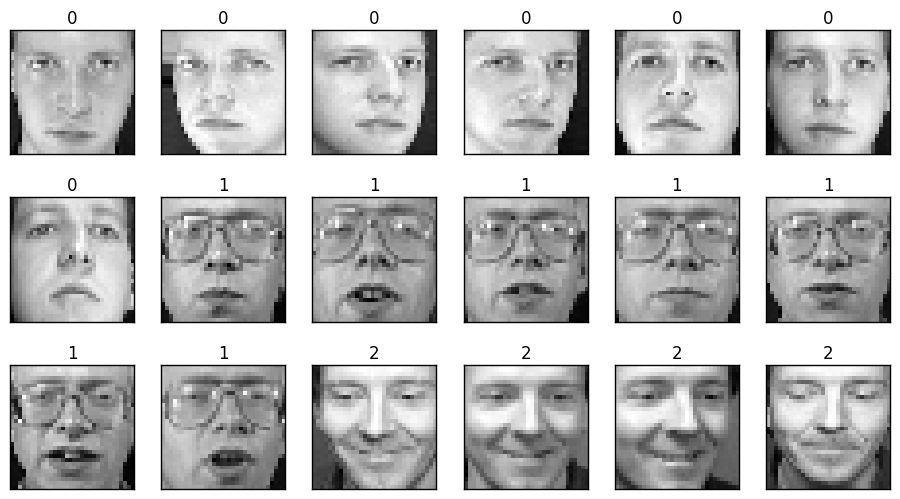

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_score = accuracy_score(y_pred, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.783333333333


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [127]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.

eps = 1e-10

def feature_scaling(img):
    m = mean(img)
    s = std(img)
    return (img - m) * 1. / s

X_train_processed = []
for i in range(len(X_train)):
    X_train_processed.append(feature_scaling(X_train[i]))
    
X_test_processed = []
for i in range(len(X_test)):
    X_test_processed.append(feature_scaling(X_test[i]))

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [128]:
from sklearn.decomposition import RandomizedPCA

n_components = 64

pca = RandomizedPCA(n_components).fit(X_train_processed)
X_train_pca = pca.transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)
# Populate 'pca' with a trained instance of RamdomizedPCA.

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


We plot a bunch of principal components.

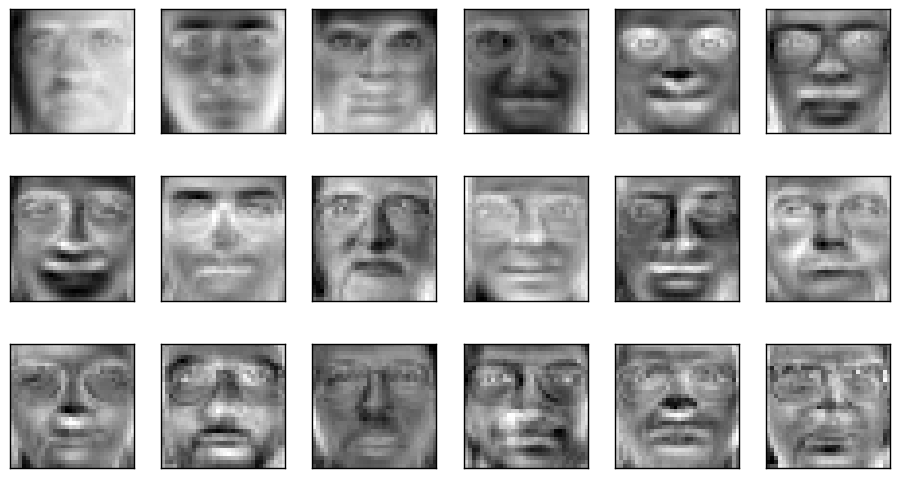

In [138]:
plot_gallery(pca.components_, None, image_h, image_w)

Transform training data, train an SVM and apply it to the encoded test data.

In [129]:
# Populate 'test_score' with test accuracy of an SVM classifier.

from sklearn.svm import SVC

clf = SVC().fit(X_train_pca, y_train) 
y_pred = clf.predict(X_test_pca)
test_score = accuracy_score(y_pred, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.716666666667


How many components are sufficient to reach the same accuracy level?

In [134]:
clf = SVC().fit(X_train_processed, y_train)
y_pred = clf.predict(X_test_processed)
accuracy_score(y_pred, y_test)

0.89166666666666672

Max accuracy: 0.891666666667


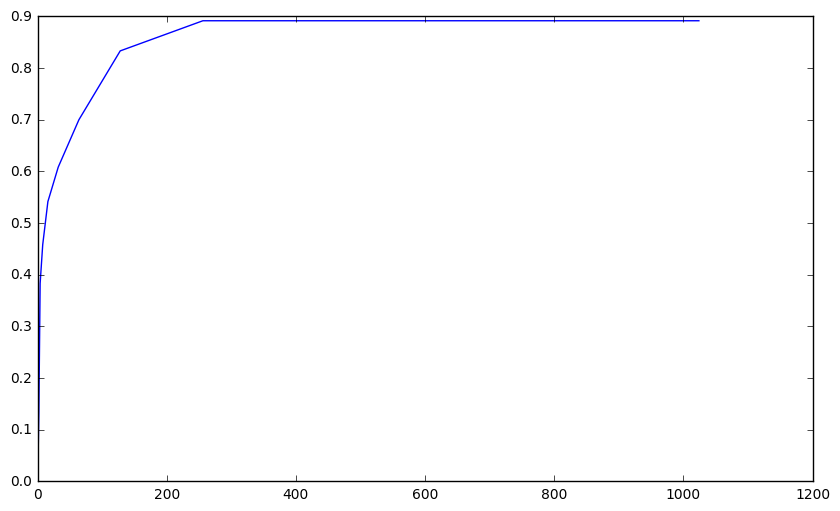

In [135]:
from sklearn.decomposition import PCA

n_components = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.
    
for k in n_components:
    pca = PCA(n_components=k, svd_solver='randomized')
    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)
    clf = SVC().fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy.append(accuracy_score(y_pred, y_test))
        
    
plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))

Вывод: достаточно 256 компонент